In [2]:
import os, sys, csv
from nilearn import masking
import nibabel as nb
from nibabel.affines import apply_affine
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# get component and concordance vectors for one subject

In [3]:
def distance_to_lesion(comp_file, concor_file, 
                       gm_file, les_file, model='spear'):

    COMP     = np.array(nb.load(comp_file).get_data())
    CONCOR   = np.array(nb.load(concor_file).get_data())
    
    gm_mask = nb.load(gm_file).get_data()
    x    = np.where(gm_mask==1)[0]
    y    = np.where(gm_mask==1)[1]
    z    = np.where(gm_mask==1)[2]

    COMPONENT   = COMP[x,y,z]
    CONCORDANCE = CONCOR[x,y,z]

    # where would be the lesion along the component
    lesion = np.array(nb.load(les_file).get_data())
    x_le   = np.where(lesion==1)[0]
    y_le   = np.where(lesion==1)[1]
    z_le   = np.where(lesion==1)[2]

    LESION = COMP[x_le, y_le, z_le]

    # define distance array
    d = np.zeros(len(COMPONENT))

    for i in range(0, len(COMPONENT)):        
            d[i] = min(abs(COMPONENT[i] - LESION))
    
    if model == 'spear':
        r, p = stats.spearmanr(d, CONCORDANCE)
    elif model == 'pear':
        r, p = stats.pearsonr(d, CONCORDANCE)
        
    return d, CONCORDANCE, COMPONENT, LESION, r, p

In [4]:
data_dir  = '/data/pt_mar006/subjects_masks/'

comp_file_list = ['/data/pt_mar006/components/mni3_component_1.nii.gz',
                  '/data/pt_mar006/components/mni3_component_2.nii.gz',
                  '/data/pt_mar006/components/mni3_component_3.nii.gz']

comp_columns = ['comp_1', #'comp_1_pval',
                'comp_2', #'comp_2_pval', 
                'comp_3', #'comp_3_pval']
                ]

list_name    = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'
with open(list_name) as f:
    subject_list = f.read().splitlines()

# distance map obtained in anatomical space

In [11]:
# get anatomical distance to the lesion
def distance_eucl(mni_file,
                  conc_file,
                  gm_file,
                  les_file,
                  model = 'spear'):

    mni_vol = nb.load(mni_file)
    mni_data = mni_vol.get_data()

    lesion = np.array(nb.load(les_file).get_data())
    lesion_xyz = np.array(np.where(lesion==1))

    # source_regions = np.where(lesion areas)
    # target_regions = np.where(grey matter mask - lesions)

    # get coordinates in MNI space for source_regions volume locations
    b = []
    for i in range(0, np.shape(lesion_xyz)[1]):
        xyz_coord = lesion_xyz[:, i]
        b.append(apply_affine(mni_vol.affine, xyz_coord))

    # target_regions = np.where(grey matter mask - lesions)
    gm_target = np.array(nb.load(gm_file).get_data())
    gm_mask = np.array(np.where(gm_target==1))

    dist_anat = []
    for idx in range(0, np.shape(gm_mask)[1]):

        gm_xyz = gm_mask[:, idx]
        a = apply_affine(mni_vol.affine, gm_xyz)
        # calculate euclidean distance to all source regions (b)
        d = np.linalg.norm(a-b)
        # keep minimum (closest)
        dist_anat.append(np.min(d))
        
    conc = np.array(nb.load(conc_file).get_data())
    x_le = gm_mask[0]
    y_le = gm_mask[1]
    z_le = gm_mask[2]

    concordance = conc[x_le, y_le, z_le]
    
    if model == 'spear':
        r, p = stats.spearmanr(dist_anat, concordance)
    elif model == 'pear':
        r, p = stats.pearsonr(dist_anat, concordance)

    return dist_anat, concordance, r

# example subject... 

Spearman correlation:  0.225859705430834
linear_model slope: 0.0006739777276504656


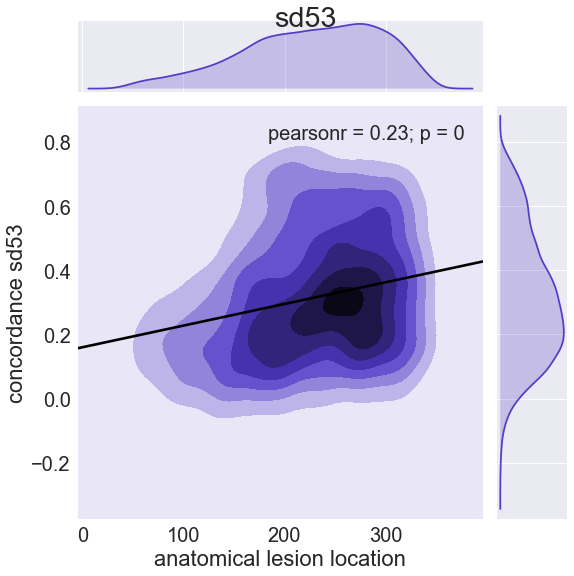

In [12]:
mni_file  = '/data/pt_mar006/subjects_group/MNI152_T1_3mm_brain.nii.gz'
data_dir  = '/data/pt_mar006/subjects_masks/'

comp_file = '/data/pt_mar006/subjects_group/mni3_component_1.nii.gz'

concordance_file_name = 'conc_ccc.nii.gz'

subject_id = 'sd53'
    
concor_file = os.path.join(data_dir, subject_id, concordance_file_name)
gm_file     = os.path.join(data_dir, subject_id, 'gm_mask_no_lesion.nii.gz')
les_file    = os.path.join(data_dir, subject_id, 'lesion_mask_mni_gm.nii.gz')


dist_anat, concordance, r = distance_eucl(mni_file,
                                           concor_file,
                                           gm_file,
                                           les_file,
                                           model = 'spear')
print "Spearman correlation: ", r

sns.set(font_scale=2)
g = sns.jointplot(x=np.array(dist_anat), 
                  y=concordance, kind="kde", 
                  color="#533cc6", size=8)

g.set_axis_labels("anatomical lesion location", 
                  "concordance %s" % subject_id)
g.fig.suptitle('%s' % (subject_id))

from sklearn import linear_model
x_reg_euc = np.expand_dims(dist_anat, axis=1)
y_reg_euc = np.expand_dims(concordance, axis=1)
regr_euc = linear_model.LinearRegression()
regr_euc.fit(x_reg_euc, y_reg_euc)
print 'linear_model slope: %s' %regr_euc.coef_[0,0]

sns.regplot(x_reg_euc.squeeze(), 
            regr_euc.predict(x_reg_euc).squeeze(), 
            ax=g.ax_joint, scatter=False, color='black')


# anatomical space - group level

In [13]:
mni_file  = '/data/pt_mar006/subjects_group/MNI152_T1_3mm_brain.nii.gz'
data_dir  = '/data/pt_mar006/subjects_masks/'
list_name    = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'

with open(list_name) as f:
    subject_list_3rs = f.read().splitlines()

    concordance_file_name = 'conc_ccc.nii.gz'

    
rAnat = pd.DataFrame(index=subject_list_3rs, 
                     columns=['r_pear'])
 
for subject_id in subject_list_3rs:
    # get filenames...
    gm_file     = os.path.join(data_dir, subject_id, 
                              'gm_mask_no_lesion.nii.gz')
    conc_file   = os.path.join(data_dir, subject_id, 
                               concordance_file_name)
    les_file    = os.path.join(data_dir, subject_id, 
                               'lesion_mask_mni_gm.nii.gz')
    
    dist_anat, concordance, r2 = distance_eucl(mni_file,
                                               conc_file,
                                               gm_file,
                                               les_file,
                                               model = 'pear')
    rAnat.ix[subject_id]['r_pear'] = r2
    

In [15]:
def plot_single_box(dataframe, df_column):
    
    fig, ax1 = plt.subplots(1, 1,  figsize=(7,11.7))

    ax1.set(ylim=(-0.404, 0.604))

    sns.set(context="paper", 
        font="sans-serif", 
        font_scale=5,
        style="whitegrid",
        rc={"grid.linewidth": 5},
        palette='Set2'
        )
    cols=[df_column]

    sns.boxplot(data=dataframe[cols], 
            linewidth = 5,
            color='white',
            ax=ax1)
    
    sns.swarmplot(data=dataframe[cols],
              color='k',
              size = 13,
              ax=ax1)
   
    #sns.swarmplot(data=dataframe[cols], color='#8A2BE2',
    #              linewidth=3, ax=ax1)

    x_axis = 0.63
    for col in cols:    
        r = dataframe.median()[col]    
        # wilcoxon signed-rank test
        t, p = stats.wilcoxon(np.array(dataframe[col], dtype=float), 
                              y=None, zero_method='zsplit', 
                              correction=True)
        # one-tailed
        p = p/2.
        
        #fig.text(x_axis, 0.90, "$\widetilde{r}=$%.2f" % (r), fontname='sans-serif', 
        # size=32, rotation=0, backgroundcolor = 'white', color = 'k',
        # ha="center", va="center")
        if p < 0.025 and t > 0:
            fig.text(x_axis, 0.815, "*" % (p), fontname='sans-serif',
            size=73, rotation=0, backgroundcolor = 'white', color = 'k',
            ha="center", va="center")
            
        x_axis += 0.4
        
    ax1.set(ylabel='Pearson\'s correlation coefficients',
            xlabel = ' ')
    fig.tight_layout()
    return fig


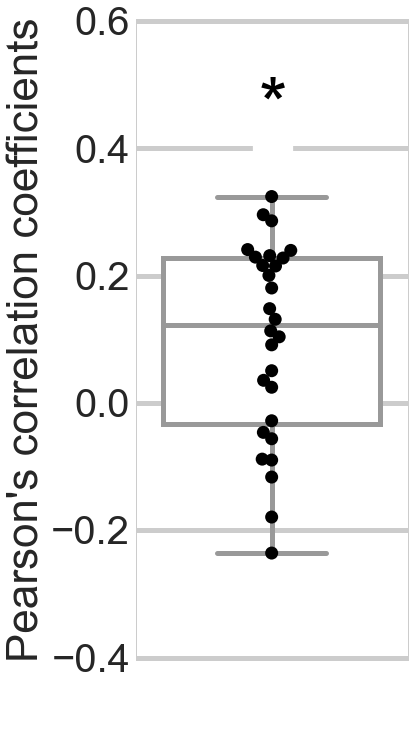

In [18]:
rComps = rAnat.copy()

rComps.rename(columns={"r_pear": " "}, inplace=True)

figure = plot_single_box(rComps, ' ')

In [19]:
rAnat['r_pear'].min(), rAnat['r_pear'].max()

(-0.23569539476102086, 0.3243861856753316)

In [20]:
rAnat['r_pear'].median()

0.12246717228419907

In [21]:
t, p = stats.wilcoxon(np.array(rAnat.r_pear, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)
t, p

(77.0, 0.004265708421448316)

# regress out anatomical space from gradient space

In [35]:
def df_reg_spearma(concordance_file_name,
                   comp_columns, 
                   comp_file_list, 
                   data_dir, 
                   subject_list, 
                   mni_file):

    # create data frame'
    rComps = pd.DataFrame(index=subject_list, 
                          columns=comp_columns)
        
    for comp_file in comp_file_list:

        col = 'comp_' + os.path.basename(comp_file[-8:-7])
        print col
        
        for subject_id in subject_list:

            # get filenames...
            gm_file     = os.path.join(data_dir, subject_id, 
                                       'gm_mask_no_lesion.nii.gz')
            conc_file   = os.path.join(data_dir, subject_id, 
                                       concordance_file_name)
            les_file    = os.path.join(data_dir, subject_id, 
                                       'lesion_mask_mni_gm.nii.gz')

            dist_anat, concordance, r1 = distance_eucl(mni_file,
                                                       conc_file,
                                                       gm_file,
                                                       les_file,
                                                       model = 'pear')
            
            dist_anat = np.array(dist_anat)

            dist_func, CONC, COMP, LES, r2, p2 = distance_to_lesion(comp_file, 
                                                                concor_file, 
                                                                gm_file, 
                                                                les_file, 
                                                                model='spear')
        
            dist_func = dist_func.squeeze()
            
            # quantify the correlation between concordance and dist_anat
            conc_anat_r = stats.pearsonr(concordance, dist_anat)[0]

            # calculate the residuals for concordance
            conc_slope  = conc_anat_r * np.std(concordance) / np.std(dist_anat)
            conc_intcp  = np.mean(concordance) - conc_slope * np.mean(dist_anat)
            conc_resid  = concordance - (conc_intcp + conc_slope * dist_anat)
            
            # correlation after regressing out dist_anat from the concordance
            r_regressed = stats.spearmanr(conc_resid, dist_func)[0]
            
            rComps.ix[subject_id][col] = r_regressed   
            
    return rComps

In [33]:
mni_file  = '/data/pt_mar006/subjects_group/MNI152_T1_3mm_brain.nii.gz'
data_dir  = '/data/pt_mar006/subjects_masks/'

comp_file_list = ['/data/pt_mar006/components/mni3_component_1.nii.gz',
                  '/data/pt_mar006/components/mni3_component_2.nii.gz',
                  '/data/pt_mar006/components/mni3_component_3.nii.gz']

comp_columns = ['comp_1',
                'comp_2', 
                'comp_3']

# only subjects having complete 3 resting-state scans
list_name    = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'
with open(list_name) as f:
    subject_list_3rs = f.read().splitlines()

## CCC - regressing anatomical space

In [36]:
df_ccc_regress = df_reg_spearma('conc_ccc.nii.gz',
                                 comp_columns, 
                                 comp_file_list, 
                                 data_dir, 
                                 subject_list_3rs, 
                                 mni_file)

comp_1
comp_2
comp_3


In [41]:
def plot_three_gradients_wilcox(rComps):

    fig = plt.figure(figsize=(11.7,11.7))
    ax1 = plt.subplot(1,1,1)
   
    sns.set(context="paper", 
            font="sans-serif", 
            font_scale=5.0,
            style="whitegrid",
            rc={"grid.linewidth": 5},
            palette='Set2'
            )
    
    sns.boxplot(data=rComps, 
                linewidth = 5,
                color='white',
                ax=ax1)
    
    #plt.setp(ax1.lines, color=".3")
    sns.swarmplot(data=rComps,
                  color='k',
                  size = 13,
                  ax=ax1)
    # one-tailed Wilcoxon signed-rank test 
    from scipy import stats
    popmean=0
    cols = ['Gradient 1',
            'Gradient 2',
            'Gradient 3']
    
    x_axis = 0.335
    for col in cols:        
        r    = rComps[col].median()
        
        t, p = stats.wilcoxon(np.array(rComps[col], dtype=float), 
                              y=None, zero_method='zsplit', 
                              correction=True)
        # one-tailed
        p = p
        
        if p < 0.05 and t > 0:
            fig.text(x_axis, 0.815, "*" % (p), fontname='sans-serif', 
                     size=73, rotation=0, backgroundcolor = 'white', color = 'k',
                     ha="center", va="center")
            
        x_axis += 0.24
    ax1.set(ylim=(-0.405, 0.604))
    ax1.set(ylabel='Spearman\'s correlation coefficients')
    fig.tight_layout()    
    return fig

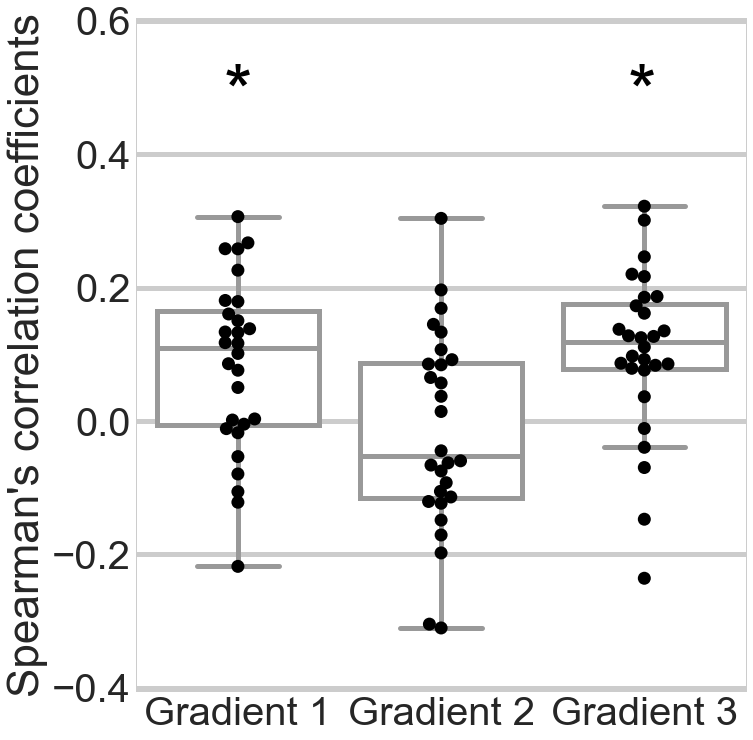

In [42]:
rComps = df_ccc_regress

rComps = rComps.rename(columns={"comp_1": "Gradient 1",
                                "comp_2": "Gradient 2",
                                "comp_3": "Gradient 3"})



fig = plot_three_gradients_wilcox(rComps)


In [43]:
df_ccc_regress.comp_1.median()

0.1088819887160076

In [44]:
t, p = stats.wilcoxon(np.array(df_ccc_regress.comp_1, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)
t, p

(78.0, 0.004581963085837361)

In [46]:
df_ccc_regress.comp_2.median()

-0.05219045673184238

In [45]:
t, p = stats.wilcoxon(np.array(df_ccc_regress.comp_2, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)
t, p

(173.0, 0.5017384136482845)

In [47]:
df_ccc_regress.comp_3.median()

0.11788463508152096

In [48]:
t, p = stats.wilcoxon(np.array(df_ccc_regress.comp_3, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)
t, p

(51.0, 0.0005608552274194569)